# LAB8 tutorial for Machine Learning <br/> Convolutional Neural Network
> 11912911 张子越

## LAB Assignment
### Exercise 1  Image Classifier(100 points )
Follow the above instructions of Image Classifier Training with PyTorch to train your own image classifier (using the [CIFAR10 dataset](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

Please try to improve performance of classification by trying different network structures (add layers, modify parameters and so on) and different training strategies (loss function, optimizer and so on). 

<font color='red' size=5>Note: Your accuracy in this exercise will directly determine your score.</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms

torch.multiprocessing.set_sharing_strategy('file_system')

import warnings
warnings.filterwarnings("ignore") 

%matplotlib inline

n_epochs = 10
batch_size = 4
learning_rate = 0.01
random_seed = 1

torch.manual_seed(random_seed)
device = torch.device('cpu')


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


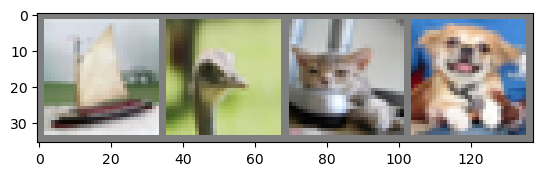

ship  bird  cat   dog  


In [2]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
from torch.nn import functional

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device=device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

In [5]:
# for epoch in range(10):  # loop over the dataset multiple times
#
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#
#         # zero the parameter gradients
#         optimizer.zero_grad()
#
#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#
#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0
#
# print('Finished Training')

In [6]:
# training

from tqdm import tqdm

history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}

for epoch in range(1, n_epochs+1):  # loop over the dataset multiple times
    processBar = tqdm(trainloader, unit='step')

    train_loss_total = 0.0

    net.train()

    for step, (inputs, labels) in enumerate(processBar):
        # get the inputs; data is a list of [inputs, labels]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]

        loss.backward()
        optimizer.step()

        processBar.set_description(
            f'Training... [{epoch}/{n_epochs}] Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}'
        )

        # print statistics
        train_loss_total += loss

        if step == len(processBar) - 1:
            correct, test_loss_total = 0,0
            totalSize = 0
            net.eval()
            for testImgs, labels in testloader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)

                outputs = net(testImgs)
                loss = criterion(outputs, labels)
                totalSize += labels.size(0)
                test_loss_total += loss
                predictions = torch.argmax(outputs, dim=1)
                correct += torch.sum(predictions == labels)

            test_accuracy = correct / totalSize
            test_loss     = test_loss_total / len(testloader)
            train_loss    = train_loss_total / len(trainloader)

            history['Train Loss'].append(train_loss.item())
            history['Test Loss' ].append(test_loss .item())
            history['Test Accuracy'].append(test_accuracy.item())
            processBar.set_description(
                f'Testing... [{epoch}/{n_epochs}] Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Acc: {test_accuracy.item():.4f}'
            )

    processBar.close()


print('Finished Training')

Testing... [1/10] Loss: 1.1504, Acc: 0.2500, Test Loss: 1.4088, Test Acc
Testing... [2/10] Loss: 1.3994, Acc: 0.5000, Test Loss: 1.4399, Test Acc
Testing... [3/10] Loss: 0.6384, Acc: 0.5000, Test Loss: 1.2467, Test Acc
Testing... [4/10] Loss: 0.7888, Acc: 0.7500, Test Loss: 1.2435, Test Acc
Testing... [5/10] Loss: 1.4333, Acc: 0.2500, Test Loss: 1.1688, Test Acc
Testing... [6/10] Loss: 0.5400, Acc: 1.0000, Test Loss: 1.2455, Test Acc
Testing... [7/10] Loss: 1.0312, Acc: 0.7500, Test Loss: 1.2961, Test Acc
Testing... [8/10] Loss: 0.7378, Acc: 1.0000, Test Loss: 1.1974, Test Acc
Testing... [9/10] Loss: 0.4770, Acc: 1.0000, Test Loss: 1.2239, Test Acc
Testing... [10/10] Loss: 0.5292, Acc: 0.7500, Test Loss: 1.3195, Test Ac

Finished Training


In [7]:
# save the model
PATH = './models/cifar10.pth'

print(net)
torch.save(net.state_dict(), PATH)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


RuntimeError: Parent directory ./models does not exist.

In [ ]:
# load the model

model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
#fig=plt.figure(figsize=(10, 8), dpi=60)
#对测试Loss进行可视化
plt.plot(history['Train Loss'],label = 'Train Loss')
plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
#对测试准确率进行可视化
plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Test the network

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

net.eval()
outputs = net(images)

_, predicted = torch.max(outputs, dim=1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        net.eval()
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

### Exercise 2  Questions (4 points )
1. Can neural networks be used for unsupervised clustering or data dimension reduction? Why?

2. What are the strengths of neural networks; when do they perform well?

3. What are the weaknesses of neural networks; when do they perform poorly?

4. What makes neural networks a good candidate for the classification regression problem, if you have enough knowledge about the data?

Answer:
=======

(1): 



(2):



(3):



(4):



